In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("Gemini_1INCHUSD_1h.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(df['date'])
df.head(n=10)

,unix,date,symbol,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,,,,
2022-04-27 00:00:00,1651017600000,2022-04-27 00:00:00,1INCH/USD,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1651014000000,2022-04-26 23:00:00,1INCH/USD,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1651010400000,2022-04-26 22:00:00,1INCH/USD,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1651006800000,2022-04-26 21:00:00,1INCH/USD,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1651003200000,2022-04-26 20:00:00,1INCH/USD,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620
2022-04-26 19:00:00,1650999600000,2022-04-26 19:00:00,1INCH/USD,1.3203,1.3240,1.2917,1.3053,12134.329536,15838.940343
2022-04-26 18:00:00,1650996000000,2022-04-26 18:00:00,1INCH/USD,1.3213,1.3213,1.3105,1.3203,460.162917,607.553099
2022-04-26 17:00:00,1650992400000,2022-04-26 17:00:00,1INCH/USD,1.3324,1.3324,1.3104,1.3213,2447.070851,3233.314715
2022-04-26 16:00:00,1650988800000,2022-04-26 16:00:00,1INCH/USD,1.3181,1.3362,1.3092,1.3324,1160.667932,1546.473953


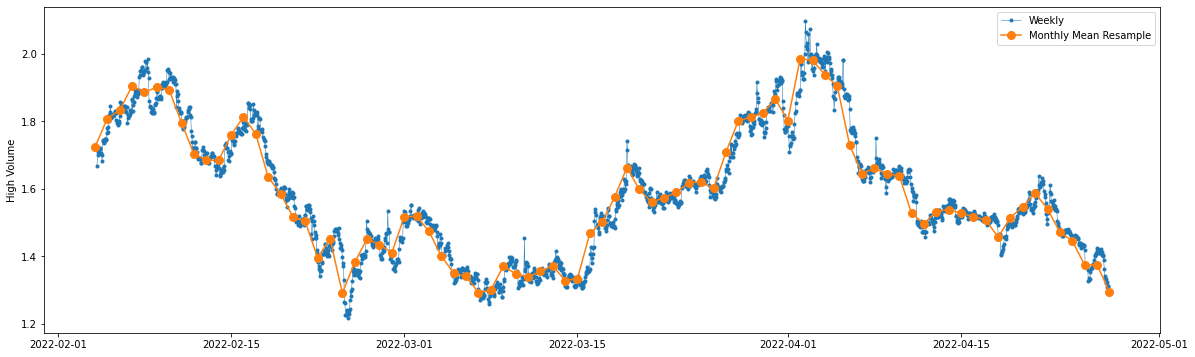

In [3]:
import warnings
import matplotlib.pyplot as plt
y = df['high']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('D').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('High Volume')
ax.legend()

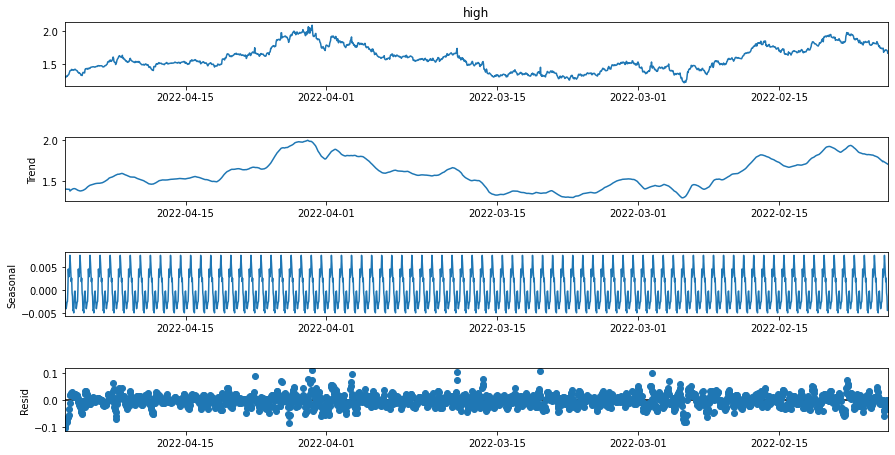

In [4]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(y)

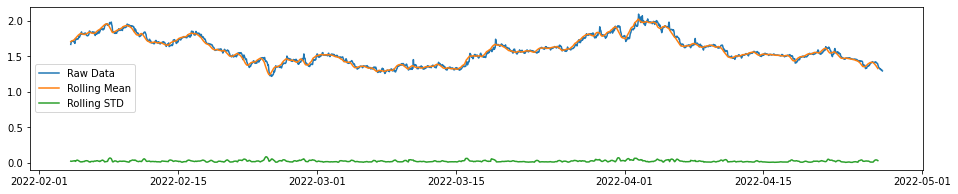

In [5]:
def test_stationary(timeSeries, title):
    rolling_mean = pd.Series(timeSeries).rolling(window = 12).mean()
    rolling_std = pd.Series(timeSeries).rolling(window = 12).std()
    
    fig, ax = plt.subplots(figsize = (16,3))
    ax.plot(timeSeries, label = title)
    ax.plot(rolling_mean, label = "Rolling Mean")
    ax.plot(rolling_std, label = "Rolling STD")
    ax.legend()

test_stationary(y, "Raw Data")

 > Is the raw data stationary ?
Test statistic = -2.115
P-value = 0.239
Critical values :
	1%: -3.433690757634069 - The data is not stationary with 99% confidence
	5%: -2.8630157503198075 - The data is not stationary with 95% confidence
	10%: -2.5675556291649313 - The data is not stationary with 90% confidence
 > Is the de-trended data stationary ?
Test statistic = -15.198
P-value = 0.000
Critical values :
	1%: -3.433704467332038 - The data is  stationary with 99% confidence
	5%: -2.8630218030562116 - The data is  stationary with 95% confidence
	10%: -2.5675588519656176 - The data is  stationary with 90% confidence


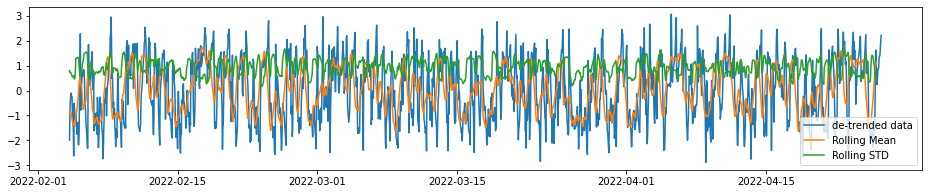

In [8]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(y,'raw data')
y_detrend =  (y - y.rolling(window=12).mean()) / y.rolling(window=12).std()

test_stationary(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -6.974
P-value = 0.000
Critical values :
	1%: -3.4337462799795997 - The data is  stationary with 99% confidence
	5%: -2.863040262878468 - The data is  stationary with 95% confidence
	10%: -2.5675686809907714 - The data is  stationary with 90% confidence


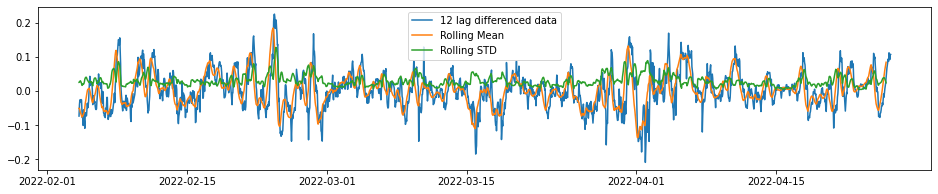

In [11]:
y_12lag =  y - y.shift(12)

test_stationary(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -10.711
P-value = 0.000
Critical values :
	1%: -3.4337657944732745 - The data is  stationary with 99% confidence
	5%: -2.863048878223751 - The data is  stationary with 95% confidence
	10%: -2.567573268289192 - The data is  stationary with 90% confidence


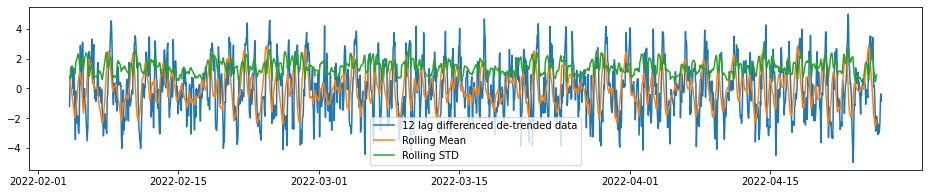

In [10]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationary(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')